In [1]:
import tensorflow as tf
import unicodedata
import string
import numpy as np
import re
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
keras = tf.keras
print(tf.__version__)

2.5.0


In [5]:
!wget https://www.manythings.org/anki/fra-eng.zip
!unzip  fra-eng.zip

--2021-07-12 12:56:55--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 172.67.173.198, 104.21.55.222, 2606:4700:3031::6815:37de, ...
Connecting to www.manythings.org (www.manythings.org)|172.67.173.198|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6444324 (6.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.15M  23.6MB/s    in 0.3s    

2021-07-12 12:56:56 (23.6 MB/s) - ‘fra-eng.zip’ saved [6444324/6444324]

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [6]:
SOS_token = 0
EOS_token = 1

In [7]:
class Lang(object):
    def __init__(self, name):
        self.name = name
        self.word2int = {}
        self.word2count = {}
        self.int2word = {0 : "SOS", 1 : "EOS"}
        self.n_words = 2
        
    def addWord(self, word):
        if word not in self.word2int:
            self.word2int[word] = self.n_words
            self.word2count[word] = 1
            self.int2word[self.n_words] = word
            self.n_words += 1
            
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)

In [8]:
def unicodeToAscii(s):
    return "".join(c for c in unicodedata.normalize("NFD", s) \
                   if unicodedata.category(c) != "Mn")

In [9]:
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    
    s = re.sub(r"([!.?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z?.!]+", " ", s)
    return s

In [10]:
def load_dataset():
    with open("fra.txt",'r') as f:
        lines = f.readlines()
    
    pairs = [[normalizeString(pair) for pair in 
              line.strip().split('\t')] for line in lines]
    return pairs

In [11]:
pairs = load_dataset()
pairs[0]

['go .', 'va !', 'cc by . france attribution tatoeba .org cm wittydev ']

In [12]:
MAX_LENGTH = 10
def sentencetoIndexes(sentence, lang):
    indexes = [lang.word2int[word] for word in sentence.split()]
    indexes.append(EOS_token)
    return indexes

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

pairs = filterPairs(pairs)

In [13]:
print(pairs[0])

['go .', 'va !', 'cc by . france attribution tatoeba .org cm wittydev ']


In [14]:
def build_lang(lang1, lang2, max_length=10):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    input_seq = []
    output_seq = []
    
    for pair in pairs:
        input_lang.addSentence(pair[1])
        output_lang.addSentence(pair[0])
    for pair in pairs:
        input_seq.append(sentencetoIndexes(pair[1], input_lang))
        output_seq.append(sentencetoIndexes(pair[0], output_lang))
    return keras.preprocessing.sequence.pad_sequences(input_seq, \
                                                      maxlen=max_length, \
                                                      padding='post',
                                                      truncating='post'), \
keras.preprocessing.sequence.pad_sequences(output_seq, padding='post', \
                                           truncating='post'), input_lang, \
                                           output_lang

In [15]:
input_tensor, output_tensor, input_lang, output_lang = build_lang('fr', 'en')

In [16]:
input_lang.name

'fr'

In [17]:
BATCH_SIZE = 16
BUFFER_SIZE = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [18]:
class Encoder(keras.models.Model):
    def __init__(self, vocab_size, num_hidden=256, num_embedding=256, batch_size=16):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.num_embedding = num_embedding
        self.embedding = keras.layers.Embedding(vocab_size, num_embedding)
        self.gru = keras.layers.GRU(num_hidden, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                   return_state=True)
        
    def call(self, x, hidden):
        embedded = self.embedding(x)
        rnn_out, hidden = self.gru(embedded, initial_state=hidden)
        return rnn_out, hidden
    def init_hidden(self):
        return tf.zeros(shape=(self.batch_size, self.num_hidden))

In [19]:
inputs, outputs = next(iter(dataset))
hidden = tf.zeros((16, 256))

In [20]:
encoder = Encoder(input_lang.n_words)

In [21]:
e_outputs, e_hidden = encoder(inputs, hidden)

In [22]:
e_hidden

<tf.Tensor: shape=(16, 256), dtype=float32, numpy=
array([[ 0.00034276,  0.02808314,  0.01045971, ..., -0.00757822,
         0.01134047,  0.02701335],
       [-0.00848547,  0.04085872,  0.01802279, ..., -0.00620697,
         0.01674816,  0.02879411],
       [ 0.00024312,  0.02611962,  0.00476594, ..., -0.01048841,
         0.01061282,  0.02209924],
       ...,
       [ 0.00351374,  0.02654258,  0.01044438, ..., -0.00841664,
         0.01311381,  0.02593761],
       [ 0.01113277,  0.00980283,  0.00015627, ..., -0.01919041,
         0.0280209 ,  0.02877855],
       [ 0.00208882,  0.02278279,  0.00614321, ..., -0.0093428 ,
         0.01605869,  0.0210402 ]], dtype=float32)>

In [23]:
class BahdanauAttention(keras.models.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
    
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, encoder_out, hidden):
        #shape of encoder_out : batch_size, seq_length, hidden_dim 
        #shape of encoder_hidden : batch_size, hidden_dim 
        
        hidden = tf.expand_dims(hidden, axis=1) #out:
        
        score = self.V(tf.nn.tanh(self.W1(encoder_out) + \
                                  self.W2(hidden))) 
        
        attn_weights = tf.nn.softmax(score, axis=1)
        
        context =  attn_weights * encoder_out 
        context = tf.reduce_sum(context, axis=1)
        return context, attn_weights
        

In [24]:
attn = BahdanauAttention(256)

In [25]:
context, attn_weights = attn(e_outputs, e_hidden)

In [26]:
attn_weights.shape

TensorShape([16, 10, 1])

In [27]:
class Decoder(keras.models.Model):
    def __init__(self, vocab_size, dec_dim=256, embedding_dim=256):
        super(Decoder, self).__init__()
        
        self.attn = BahdanauAttention(dec_dim)
        self.embedding = keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = keras.layers.GRU(dec_dim, recurrent_initializer='glorot_uniform',
                                   return_sequences=True, return_state=True)
        self.fc = keras.layers.Dense(vocab_size)
        
    def call(self, x, enc_hidden, enc_out):
        x = self.embedding(x)
        context, attn_weights = self.attn(enc_out, enc_hidden)
        x = tf.concat((tf.expand_dims(context, 1), x), -1)
        r_out, hidden = self.gru(x, initial_state=enc_hidden)
        out = tf.reshape(r_out,shape=(-1, r_out.shape[2]))
        return self.fc(out), hidden, attn_weights

In [28]:
decoder = Decoder(output_lang.n_words)

In [29]:
input_tensor, output_tensor = next(iter(dataset))

In [30]:
x = np.expand_dims(output_tensor[:,1], -1)

In [31]:
def loss_fn(real, pred):
    criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                           reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    _loss = criterion(real, pred)
    mask = tf.cast(mask, dtype=_loss.dtype)
    _loss *= mask
    return tf.reduce_mean(_loss)

In [32]:
optimizer = tf.optimizers.Adam()

In [33]:
def train_step(input_tensor, target_tensor, enc_hidden):
    loss = 0.0
    with tf.GradientTape() as tape:
    
        batch_size = input_tensor.shape[0]
        enc_output, enc_hidden = encoder(input_tensor, enc_hidden)

        SOS_tensor = np.array([SOS_token])
        dec_input = tf.squeeze(tf.expand_dims([SOS_tensor]*batch_size, 1), -1)
        dec_hidden = enc_hidden

        for tx in range(target_tensor.shape[1]-1):
          
            dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                            enc_output)
            loss += loss_fn(target_tensor[:, tx], dec_out)
            dec_input = tf.expand_dims(target_tensor[:, tx], 1)

    batch_loss = loss / target_tensor.shape[1]
    t_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, t_variables)
    optimizer.apply_gradients(zip(gradients, t_variables))
    return batch_loss
    

In [34]:
hidden = tf.zeros(shape=(16, 256))
loss = train_step(input_tensor, output_tensor, hidden)
print(loss)

tf.Tensor(6.845343, shape=(), dtype=float32)


In [35]:
def checkpoint(model, name=None):
    if name is not None:
        model.save_weights('/content/gdrive/My Drive/{}_fr.h5'.format(name))
    else:
        raise NotImplementedError

In [36]:
encoder.load_weights('/content/gdrive/MyDrive/encoder_fr.h5')
decoder.load_weights('/content/gdrive/MyDrive/decoder_fr.h5')

In [ ]:
EPOCHS = 10
log_every = 50
steps_per_epoch = len(pairs) // BATCH_SIZE
loss_list = []

for e in range(1, EPOCHS):
    
    total_loss = 0.0
    enc_hidden = encoder.init_hidden()
    
    for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(input_tensor, target_tensor, hidden)
        total_loss += batch_loss
        
        if idx % log_every == 0:
            loss_list.append(batch_loss)
            print("Epochs: {} batch_loss: {:.4f}".format(e, batch_loss))
            checkpoint(encoder, 'encoder')
            checkpoint(decoder, 'decoder')
            
    if e % 2 == 0:
        print("Epochs: {}/{} total_loss: {:.4f}".format(
        e, EPOCHS, total_loss / steps_per_epoch))

In [ ]:
encoder.save_weights('/content/gdrive/MyDrive/encoder_fr.h5')
decoder.save_weights('/content/gdrive/MyDrive/decoder_fr.h5')

In [37]:
def translate(sentence, max_length=10):
    result = ''
    attention_plot = np.zeros((10,10))
    sentence = normalizeString(sentence)
    sentence = sentencetoIndexes(sentence, input_lang)
    sentence = keras.preprocessing.sequence.pad_sequences([sentence],padding='post',
                                                      maxlen=max_length, truncating='post')
    
    encoder_hidden = hidden = [tf.zeros((1, 256))]
    
    enc_out, enc_hidden = encoder(sentence, encoder_hidden)
    
    dec_hidden = enc_hidden
    SOS_tensor = np.array([SOS_token])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor], 1), -1)
    
    for tx in range(max_length):
        dec_out, dec_hidden, attn_weights = decoder(dec_input,
                                                   dec_hidden, enc_out)
        attn_weights = tf.reshape(attn_weights, (-1, ))
        attention_plot[tx] = attn_weights.numpy()
        pred = tf.argmax(dec_out, axis=1).numpy()
        result += output_lang.int2word[pred[0]] + " "
        if output_lang.int2word[pred[0]] == "EOS":
            break
        dec_input = tf.expand_dims(pred, axis=1)
    return result, attention_plot

In [40]:
sentence = "Je n'aime pas la façon dont tu me parles"
pred, attn_weights = translate(sentence)
print(pred)

i don t love the way you speak with . 


In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
    #sentence = normalizeString(sentence)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
from matplotlib import ticker

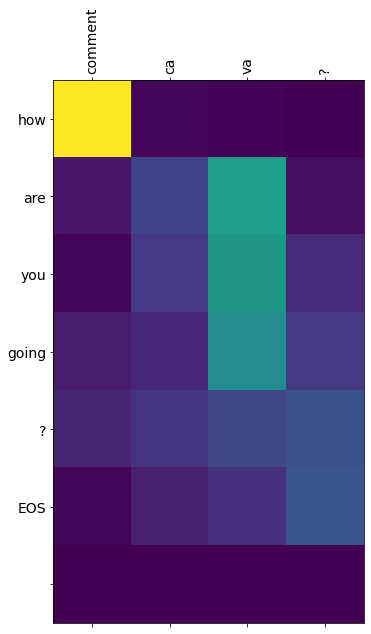

In [ ]:
attn_weights = attn_weights[:len(pred.split(' ')), :len(sentence.split(' '))]
plot_attention(attn_weights, sentence.split(), pred.split())

In [ ]:
encoder.load_weights('/content/gdrive/My Drive/encoder.h5')
decoder.load_weights('/content/gdrive/My Drive/decoder.h5')

In [ ]:

!pip install anvil-uplink


     |████████████████████████████████| 61kB 5.7MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45230 sha256=bb8721cd253ce325fbee4f4612210619d8a4d1d8a8c6362693cbaae606b56be8
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


In [ ]:
import anvil.server

anvil.server.connect("MGQSYXEMZEBIIKRHJ3PATCQG-4WA5U74KV5JQOJHG")

Disconnecting from previous connection first...
Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [ ]:
@anvil.server.callable
def translate(sentence, max_length=10):
    result = ''
    attention_plot = np.zeros((10,10))
    sentence = normalizeString(sentence)
    sentence = sentencetoIndexes(sentence, input_lang)
    sentence = keras.preprocessing.sequence.pad_sequences([sentence],padding='post',
                                                      maxlen=max_length, truncating='post')
    
    encoder_hidden = hidden = [tf.zeros((1, 256))]
    
    enc_out, enc_hidden = encoder(sentence, encoder_hidden)
    
    dec_hidden = enc_hidden
    SOS_tensor = np.array([SOS_token])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor], 1), -1)
    
    for tx in range(max_length):
        dec_out, dec_hidden, attn_weights = decoder(dec_input,
                                                   dec_hidden, enc_out)
        attn_weights = tf.reshape(attn_weights, (-1, ))
        attention_plot[tx] = attn_weights.numpy()
        pred = tf.argmax(dec_out, axis=1).numpy()
        result += output_lang.int2word[pred[0]] + " "
        if output_lang.int2word[pred[0]] == "EOS":
            break
        dec_input = tf.expand_dims(pred, axis=1)
    return result